In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as T
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.utils import data
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from skimage import io
from skimage import color
from skimage import transform
from skimage import util
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
opt_dict = {
    'n_epochs': 200, 
    'batch_size': 4, 
    'lr': 5e-05, 
    'n_cpu': 8, 
    'latent_dim': 100, 
    'img_size': 224, 
    'channels': 3, 
    'n_critic': 5, 
    'clip_value': 0.01, 
    'sample_interval': 10
    }

class AttDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttDict, self).__init__(*args, **kwargs)
        self.__dict__=self

arg = AttDict(opt_dict)

In [4]:
img_shape = (arg.channels, arg.img_size, arg.img_size)

cuda = True if torch.cuda.is_available() else False

## Dataset

In [5]:
## data loader
class ListDataset(data.Dataset):

    def __init__(self, dataset, mode, crop_size, normalization='minmax', hidden_classes=None, overlap=False, use_dsm=False):

        # Initializing variables.
        self.root = os.path.join(datapath, dataset)
        self.dataset = dataset
        self.mode = mode
        self.crop_size = crop_size
        self.normalization = normalization
        self.hidden_classes = hidden_classes
        self.overlap = overlap
        self.use_dsm = use_dsm
        
        self.num_classes = 5 # For Vaihingen and Potsdam.
            
        if self.hidden_classes is not None:
            self.n_classes = self.num_classes - len(hidden_classes)
        else:
            self.n_classes = self.num_classes

        # Creating list of paths.
        self.imgs = self.make_dataset()

        # Check for consistency in list.
        if len(self.imgs) == 0:

            raise (RuntimeError('Found 0 images, please check the data set'))

    def make_dataset(self):

        # Making sure the mode is correct.
        assert self.mode in ['Train', 'Test', 'Val']

        # Setting string for the mode.
        img_dir = os.path.join(self.root, self.mode, 'Images')
        msk_dir = os.path.join(self.root, self.mode, 'Masks')
        if self.use_dsm:
            dsm_dir = os.path.join(self.root, self.mode, 'NDSM')

        # if self.mode == 'Val':
        #     img_dir = os.path.join(self.root, 'Train', 'Images')
        #     msk_dir = os.path.join(self.root, 'Train', 'Masks')
        #     if self.use_dsm:
        #         dsm_dir = os.path.join(self.root, 'Train', 'NDSM')

        data_list = sorted([f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])

        # Creating list containing image and ground truth paths.
        items = []
        if self.dataset == 'Vaihingen':
            for it in data_list:
                item = (
                    os.path.join(img_dir, it),
                    os.path.join(msk_dir, it),
                    # os.path.join(dsm_dir, it.replace('top_mosaic_09cm_area', 'dsm_09cm_matching_area').replace('.tif', '_normalized.jpg'))
                )
                items.append(item)
        elif self.dataset == 'Potsdam':
            for it in data_list:
                if self.use_dsm:
                    item = (
                        os.path.join(img_dir, it),
                        os.path.join(msk_dir, it.replace('_IRRG.tif', '_label.tif')),
                        # os.path.join(msk_dir, it.replace('_IRRG.tif', '_label_noBoundary.tif')),
                        os.path.join(dsm_dir, it.replace('top_potsdam_', 'dsm_potsdam_').replace('_IRRG.tif', '_normalized_lastools.jpg'))
                    )
                else:
                    item = (
                        os.path.join(img_dir, it),
                        os.path.join(msk_dir, it.replace('_IRRG.tif', '_label.tif')),
                        # os.path.join(msk_dir, it.replace('_IRRG.tif', '_label_noBoundary.tif')),
                        # os.path.join(dsm_dir, it.replace('top_potsdam_', 'dsm_potsdam_').replace('_IRRG.tif', '_normalized_lastools.jpg'))
                    )
                items.append(item)
        
        # Returning list.
        return items
    
    def random_crops(self, img, msk, msk_true, n_crops):
        
        img_crop_list = []
        msk_crop_list = []
        msk_true_crop_list = []
        
        rand_fliplr = np.random.random() > 0.50
        rand_flipud = np.random.random() > 0.50
        rand_rotate = np.random.random()
        
        for i in range(n_crops):
            
            rand_y = np.random.randint(msk.shape[0] - self.crop_size[0])
            rand_x = np.random.randint(msk.shape[1] - self.crop_size[1])

            img_patch = img[rand_y:(rand_y + self.crop_size[0]),
                            rand_x:(rand_x + self.crop_size[1])]
            msk_patch = msk[rand_y:(rand_y + self.crop_size[0]),
                            rand_x:(rand_x + self.crop_size[1])]
            msk_true_patch = msk_true[rand_y:(rand_y + self.crop_size[0]),
                                      rand_x:(rand_x + self.crop_size[1])]
            
            if rand_fliplr:
                img_patch = np.fliplr(img_patch)
                msk_patch = np.fliplr(msk_patch)
                msk_true_patch = np.fliplr(msk_true_patch)
            if rand_flipud:
                img_patch = np.flipud(img_patch)
                msk_patch = np.flipud(msk_patch)
                msk_true_patch = np.flipud(msk_true_patch)
            
            if rand_rotate < 0.25:
                img_patch = transform.rotate(img_patch, 270, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 270, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 270, order=0, preserve_range=True)
            elif rand_rotate < 0.50:
                img_patch = transform.rotate(img_patch, 180, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 180, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 180, order=0, preserve_range=True)
            elif rand_rotate < 0.75:
                img_patch = transform.rotate(img_patch, 90, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 90, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 90, order=0, preserve_range=True)
                
            img_patch = img_patch.astype(np.float32)
            msk_patch = msk_patch.astype(np.int64)
            msk_true_patch = msk_true_patch.astype(np.int64)
            
            img_crop_list.append(img_patch)
            msk_crop_list.append(msk_patch)
            msk_true_crop_list.append(msk_true_patch)
        
        img = np.asarray(img_crop_list)
        msk = np.asarray(msk_crop_list)
        msk_true = np.asarray(msk_true_crop_list)
        
        return img, msk, msk_true
        
    def test_crops(self, img, msk, msk_true):
        
        n_channels = 3
        if self.use_dsm:
            n_channels = 4
        if self.overlap:
            w_img = util.view_as_windows(img,
                                         (self.crop_size[0], self.crop_size[1], n_channels),
                                         (self.crop_size[0] // 2, self.crop_size[1] // 2, n_channels)).squeeze()
            w_msk = util.view_as_windows(msk,
                                         (self.crop_size[0], self.crop_size[1]),
                                         (self.crop_size[0] // 2, self.crop_size[1] // 2))
            w_msk_true = util.view_as_windows(msk_true,
                                              (self.crop_size[0], self.crop_size[1]),
                                              (self.crop_size[0] // 2, self.crop_size[1] // 2))
        else:
            w_img = util.view_as_blocks(img, (self.crop_size[0], self.crop_size[1], n_channels)).squeeze()
            w_msk = util.view_as_blocks(msk, (self.crop_size[0], self.crop_size[1]))
            w_msk_true = util.view_as_blocks(msk_true, (self.crop_size[0], self.crop_size[1]))
        
        return w_img, w_msk, w_msk_true
        
    def shift_labels(self, msk):
        
        msk_true = np.copy(msk)
        
        cont = 0
        for h_c in self.hidden_classes:
            
            msk[msk == h_c - cont] = 100
            for c in range(h_c - cont + 1, self.num_classes):
                msk[msk == c] = c - 1
                msk_true[msk_true == c] = c - 1
            cont = cont + 1
        
        msk_true[msk == 100] = self.num_classes - len(self.hidden_classes)
        msk[msk == 100] = self.num_classes
        
        return msk, msk_true
    
    def mask_to_class(self, msk):
    
        msk = msk.astype(np.int64)
        new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)
        
        msk = msk // 255
        msk = msk * (1, 7, 49)
        msk = msk.sum(axis=2)

        new[msk == 1 + 7 + 49] = 0 # Street.
        new[msk ==         49] = 1 # Building.
        new[msk ==     7 + 49] = 2 # Grass.
        new[msk ==     7     ] = 3 # Tree.
        new[msk == 1 + 7     ] = 4 # Car.
        new[msk == 1         ] = 5 # Surfaces.
        new[msk == 0         ] = 6 # Boundaries.

        return new
        
    def __getitem__(self, index):
        
        # Reading items from list.
        if self.use_dsm:
            img_path, msk_path, dsm_path = self.imgs[index]
        else:
            img_path, msk_path = self.imgs[index]
        
        # Reading images.
        img_raw = io.imread(img_path)
        msk_raw = io.imread(msk_path)
        if self.use_dsm:
            dsm_raw = io.imread(dsm_path)
            
        if len(img_raw.shape) == 2:
            img_raw = color.gray2rgb(img_raw)
        
        if self.use_dsm:
            img = np.full((img_raw.shape[0] + self.crop_size[0] - (img_raw.shape[0] % self.crop_size[0]),
                           img_raw.shape[1] + self.crop_size[1] - (img_raw.shape[1] % self.crop_size[1]),
                           img_raw.shape[2] + 1),
                          fill_value=0.0,
                          dtype=np.float32)
        else:
            img = np.full((img_raw.shape[0] + self.crop_size[0] - (img_raw.shape[0] % self.crop_size[0]),
                           img_raw.shape[1] + self.crop_size[1] - (img_raw.shape[1] % self.crop_size[1]),
                           img_raw.shape[2]),
                          fill_value=0.0,
                          dtype=np.float32)
        
        msk = np.full((msk_raw.shape[0] + self.crop_size[0] - (msk_raw.shape[0] % self.crop_size[0]),
                       msk_raw.shape[1] + self.crop_size[1] - (msk_raw.shape[1] % self.crop_size[1]),
                       msk_raw.shape[2]),
                      fill_value=0,
                      dtype=np.int64)
        
        img[:img_raw.shape[0], :img_raw.shape[1], :img_raw.shape[2]] = img_raw
        if self.use_dsm:
            img[:dsm_raw.shape[0], :dsm_raw.shape[1], -1] = dsm_raw
        msk[:msk_raw.shape[0], :msk_raw.shape[1]] = msk_raw
        
        msk = self.mask_to_class(msk)
        
        msk, msk_true = self.shift_labels(msk)
        
        # Normalization.
        img = (img / 255) - 0.5
        
        if self.mode == 'Train':
            
            img, msk, msk_true = self.random_crops(img, msk, msk_true, 3)
            
            img = np.transpose(img, (0, 3, 1, 2))
        
        elif self.mode == 'Val':
            
            img, msk, msk_true = self.test_crops(img, msk, msk_true)
            
            img = np.transpose(img, (0, 1, 4, 2, 3))
            msk = np.transpose(msk, (0, 1, 2, 3))
            msk_true = np.transpose(msk_true, (0, 1, 2, 3))

            # mini = np.random.randint(img.shape[0], size=10)
            mini_in = np.random.randint(img.shape[1], size=10)

            img = img[:10, mini_in, :, :, :]
            msk = msk[:10, mini_in, :, :]
            msk_true = msk_true[:10, mini_in, :, :]

        elif self.mode == 'Test':
            
            img, msk, msk_true = self.test_crops(img, msk, msk_true)

            img = np.transpose(img, (0, 1, 4, 2, 3))
            msk = np.transpose(msk, (0, 1, 2, 3))
            msk_true = np.transpose(msk_true, (0, 1, 2, 3))

            mini_in = np.random.randint(img.shape[1], size=10)

            img = img[:10, mini_in, :, :, :]
            msk = msk[:10, mini_in, :, :]
            msk_true = msk_true[:10, mini_in, :, :]
        
        msk[msk == self.num_classes + 1] = self.num_classes
        msk_true[msk_true == self.num_classes + 1] = self.num_classes

        # Splitting path.
        spl = img_path.split('/')

        # Turning to tensors.
        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)
        msk_true = torch.from_numpy(msk_true)

        # Returning to iterator.
        return img

    def __len__(self):

        return len(self.imgs)

## T

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_size, channels):

        super(Generator, self).__init__()
         # in: latent_size x 1 x 1

        self.gen = generator = nn.Sequential(

            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Conv2d(8, channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, z):
        img = self.gen(z)
        return img


In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            # in: 3 x 64 x 64

            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1
            # Modification 1: remove sigmoid
            # nn.Sigmoid()

            )


    def forward(self, img):
        output = self.discriminator(img)
        return output


In [29]:
generator = Generator(arg.latent_dim, arg.channels)
discriminator = Discriminator(arg.channels)

In [30]:
if cuda:
    generator.cuda()
    discriminator.cuda()

In [10]:
datapath = '/content/drive/MyDrive/BTPII'
ckpt = os.path.join(datapath, 'checkpoint')

In [31]:
# generator.load_state_dict(torch.load(os.path.join(ckpt, 'generator.pt')))
generator.load_state_dict(torch.load(os.path.join(ckpt, 'dcgan_nodsm.pth'))['generator'])
generator.eval()

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(3

In [17]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

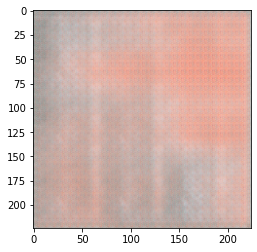

In [38]:
z = Variable(torch.randn(12, arg.latent_dim, 1, 1).type(Tensor))
# Generate a batch of images
fake_imgs = generator(z).detach()
fimgs = fake_imgs.cpu()
fimgs_0 = fimgs[0, :3, :, :].permute(1, 2, 0)
fnup = fimgs_0.numpy()
mini = np.min(fnup)
maxi = np.max(fnup)
fnup = (fnup-mini)/(maxi-mini)
plt.figure()
plt.imshow((fnup+1)/2)
plt.show()

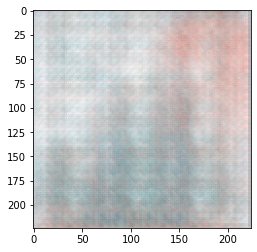

In [22]:
z = Variable(torch.randn(12, arg.latent_dim, 1, 1).type(Tensor))
# Generate a batch of images
fake_imgs = generator(z).detach()
fimgs = fake_imgs.cpu()
fimgs_0 = fimgs[0, :3, :, :].permute(1, 2, 0)
fnup = fimgs_0.numpy()
mini = np.min(fnup)
maxi = np.max(fnup)
fnup = (fnup-mini)/(maxi-mini)
plt.figure()
plt.imshow((fnup+1)/2)
plt.show()

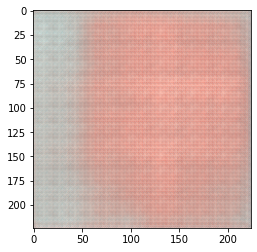

In [ ]:
# torch.random.manual_seed(15)
z = Variable(torch.randn(12, arg.latent_dim, 1, 1).type(Tensor))
# Generate a batch of images
fake_imgs = generator(z).detach()
fimgs = fake_imgs.cpu()
fimgs_0 = fimgs[0, :3, :, :].permute(1, 2, 0)
fnup = fimgs_0.numpy()
mini = np.min(fnup)
maxi = np.max(fnup)
fnup = (fnup-mini)/(maxi-mini)
plt.figure()
plt.imshow((fnup+1)/2)
plt.show()

In [ ]:
fnup

array([[[0.54593426, 0.54659605, 0.52154857],
        [0.54083556, 0.5572497 , 0.5019218 ],
        [0.52366567, 0.5148134 , 0.5144535 ],
        ...,
        [0.54140705, 0.5636074 , 0.46922436],
        [0.5316146 , 0.5180348 , 0.5292285 ],
        [0.561259  , 0.5524149 , 0.5063176 ]],

       [[0.53419584, 0.550712  , 0.4828358 ],
        [0.52233946, 0.5299142 , 0.5261663 ],
        [0.5187393 , 0.5287331 , 0.50297254],
        ...,
        [0.5370926 , 0.5408507 , 0.42438284],
        [0.5611254 , 0.5960449 , 0.50380594],
        [0.55700433, 0.564728  , 0.47314844]],

       [[0.53033596, 0.48540267, 0.541709  ],
        [0.5446853 , 0.5124878 , 0.51648617],
        [0.4972075 , 0.57151645, 0.5642034 ],
        ...,
        [0.48595935, 0.50647694, 0.5765267 ],
        [0.57261103, 0.4627932 , 0.546848  ],
        [0.5532147 , 0.5756159 , 0.5367844 ]],

       ...,

       [[0.5476298 , 0.53308856, 0.4850459 ],
        [0.5169869 , 0.536018  , 0.48895296],
        [0.55133307, 0

In [ ]:
fnup

array([[[-8.1595714e-04, -7.7497528e-04, -2.3260156e-03],
        [-1.1316894e-03, -1.1526154e-04, -3.5413816e-03],
        [-2.1949157e-03, -2.7430793e-03, -2.7653738e-03],
        ...,
        [-1.0962997e-03,  2.7843201e-04, -5.5661332e-03],
        [-1.7026871e-03, -2.5435993e-03, -1.8504446e-03],
        [ 1.3300718e-04, -4.1464914e-04, -3.2691720e-03]],

       [[-1.5428491e-03, -5.2010169e-04, -4.7232602e-03],
        [-2.2770388e-03, -1.8079845e-03, -2.0400647e-03],
        [-2.4999757e-03, -1.8811220e-03, -3.4763161e-03],
        ...,
        [-1.3634691e-03, -1.1307528e-03, -8.3428947e-03],
        [ 1.2473698e-04,  2.2870901e-03, -3.4247073e-03],
        [-1.3045648e-04,  3.4782663e-04, -5.3231400e-03]],

       [[-1.7818647e-03, -4.5643100e-03, -1.0776019e-03],
        [-8.9329912e-04, -2.8870928e-03, -2.6394976e-03],
        [-3.8333079e-03,  7.6819019e-04,  3.1533741e-04],
        ...,
        [-4.5298371e-03, -3.2593098e-03,  1.0784466e-03],
        [ 8.3597290e-04, -5.9